# Statistisk Analys
## Gjord i Python utifrån databasen AdventureWorks2022

### Inledning
AdventureWorks2022 är en exempeldatabas från Microsoft som illustrerar hur en realistisk företagsdatabas kan vara uppbyggd. Genom att analysera de olika schemana kan vi få en förståelse för företagets struktur, processer och datainsamling. Detta är avgörande för att kunna identifiera styrkor och förbättringsområden, optimera processer och fatta datadrivna beslut. Analysen består av två delar varav första delen är en deskriptiv sammanfattning av databasens fem olika scheman. Den andra delen är en fördjupad analys av säljarnas prestationer.

**Första delen**
Analysen av varje schema är viktig av följande anledningar:

- **HumanResources:** Ger insikter om företagets personalstyrka, deras rollfördelning och lönestruktur. Detta kan hjälpa till att optimera personalhanteringen.
- **Person:** Innehåller data om anställdas kontaktinformation och plats, vilket är kan säkerställa att företaget kan planera resursfördelning.
- **Production:** Analyserar produktutbud, lagerhantering och produktionsflöden för att identifiera möjligheter till effektivisering och kostnadsbesparingar.
- **Purchasing:** Hjälper till att utvärdera företagets leverantörskedja och inköpskostnader.
- **Sales:** Identifierar intäktsgenererande områden, kundbeteende och marknadstrender, vilket är avgörande för att öka försäljningen och förbättra kundupplevelsen.

**Andra delen**
Slutligen kommer jag att göra en statistik analys utifrån säljarnas prestationer och tolka resultaten, samt redogöra för rekommendationer framåt.

Syftet med detta arbete är att skapa en överskådlig analys av AdventureWorks2022, vilket kan ge insikter om hur data kan användas för att förbättra företagets lönsamhet och effektivitet.

In [21]:
import pandas as pd # Importerar bibliotek för datahantering och analys
import matplotlib.pyplot as plt # Importerar bibliotek för att skapa grafer och visualiseringar
import sqlalchemy 
from sqlalchemy import create_engine, MetaData, Table, inspect # Anslutning till databas, samt vertyg för att integrera med databasens struktur, inspektera tabeller och metadata.

# Definiera anslutningsparametrar
server = 'JOSEFINA'  # Ditt servernamn
database = 'AdventureWorks2022'  # Databasnamn
driver = 'ODBC Driver 17 for SQL Server'  # Drivrutin för SQL Server

# Skapa anslutningssträng
connection_string = f"mssql+pyodbc://@{server}/{database}?trusted_connection=yes&driver={driver}"

# Skapa engine
engine = create_engine(connection_string) # skapar ett objekt engine som hanterar antlutningen till databasen. Den används för att skicka frågor och hämta data

# Testa anslutningen
try:
    connection = engine.connect()
    print("Anslutning till SQL Server lyckades!")
except Exception as e:
    print("Kunde inte ansluta:", e)

Anslutning till SQL Server lyckades!


## Första delen - deskriptiv sammanfattning över databasen AdventureWorks2022

In [5]:
schemasinadventureworks = """
SELECT 
  SCHEMA_NAME AS SchemaName
FROM 
  INFORMATION_SCHEMA.SCHEMATA 
WHERE 
  SCHEMA_NAME NOT LIKE 'db_%' 
    AND SCHEMA_NAME NOT IN ('guest', 'sys', 'INFORMATION_SCHEMA');
"""

dataschemasinadventureworks = pd.read_sql(schemasinadventureworks, connection)

styled_dataschemasinadventureworks_table = (
    dataschemasinadventureworks.style
    .set_caption('Scheman i AdventureWorks2022')
        .set_table_styles([ 
        {
            'selector': 'caption',
            'props': [
                ('font-size', '18px'),
                ('text-align', 'center'),
                ('font-weight', 'bold'),
                ('color', '#FFF')  
            ]
        }
    ])
)

styled_dataschemasinadventureworks_table

,SchemaName
0,HumanResources
1,Person
2,Production
3,Purchasing
4,Sales


Vi har fem olika huvudkategorier/scheman i AdventureWorks2022.
Jag kommer vidare att utgå från dessa huvudkategorier när jag beskriver datan.

### HumanResources
HumanResources innehåller information om de anställda, så som avdelning, jobbtitel, lön, ålder och kön. Nedan kommer jag visa antal anställda per kön och åldersgrupp, samt medellön per avdelning och kön. Medellönen är exklusive chefer eftersom chefer ofta har en högre lön och då höjer medelvärdet vilket då inte ger en korrekt bild av de anställdas medellön. I de fall där det inte finns representativ data kommer det på denna rad att stå "NaN".


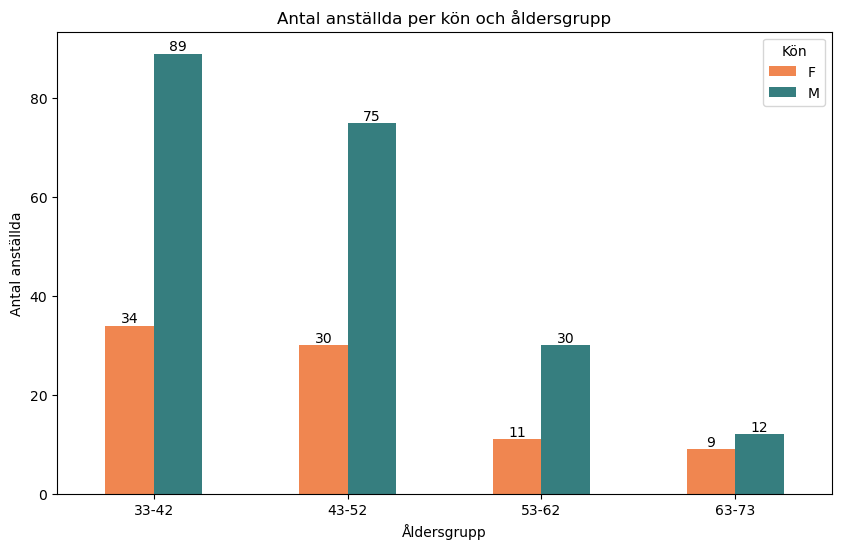

In [6]:
CountEmployee = """SELECT
	CASE
		WHEN DATEDIFF(YEAR, E.BirthDate, GETDATE()) BETWEEN 33 AND 42 THEN '33-42'
        WHEN DATEDIFF(YEAR, E.BirthDate, GETDATE()) BETWEEN 43 AND 52 THEN '43-52'
        WHEN DATEDIFF(YEAR, E.BirthDate, GETDATE()) BETWEEN 53 AND 62 THEN '53-62'
        WHEN DATEDIFF(YEAR, E.BirthDate, GETDATE()) BETWEEN 63 AND 73 THEN '63-73'
        ELSE 'Other'
		END AS AgeGroup,
		E.Gender,
		Count(*) AS EmployeeCount
FROM
	HumanResources.Employee E
LEFT JOIN 
	HumanResources.EmployeeDepartmentHistory EDH
	ON E.BusinessEntityID = EDH.BusinessEntityID
WHERE
	EDH.EndDate IS NULL -- Endast aktiva anställda
GROUP BY
    CASE 
        WHEN DATEDIFF(YEAR, E.BirthDate, GETDATE()) BETWEEN 33 AND 42 THEN '33-42'
        WHEN DATEDIFF(YEAR, E.BirthDate, GETDATE()) BETWEEN 43 AND 52 THEN '43-52'
        WHEN DATEDIFF(YEAR, E.BirthDate, GETDATE()) BETWEEN 53 AND 62 THEN '53-62'
        WHEN DATEDIFF(YEAR, E.BirthDate, GETDATE()) BETWEEN 63 AND 73 THEN '63-73'
        ELSE 'Other'
    END,
    E.Gender
ORDER BY
	AgeGroup, Gender;"""

dataCountEmployee = pd.read_sql(CountEmployee, connection)

dataCountEmployee_data = dataCountEmployee.pivot(index='AgeGroup', columns='Gender', values='EmployeeCount')

ax = dataCountEmployee_data.plot(
    kind='bar', 
    figsize=(10, 6), 
    color=['#F08650', '#367E7F']
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge') 

plt.title('Antal anställda per kön och åldersgrupp')
plt.xlabel('Åldersgrupp')
plt.ylabel('Antal anställda')
plt.xticks(rotation=0)  
plt.legend(title='Kön')

plt.show()

In [7]:
CountAVG = """SELECT
    D.Name AS Department, 
    E.Gender,
    COUNT(*) AS EmployeeCount,
    AVG(EPH.Rate) AS AverageSalary,
    AVG(DATEDIFF(YEAR, E.BirthDate, GETDATE())) AS AverageAge,
	AVG(DATEDIFF(YEAR, E.HireDate, GETDATE())) AS AverageWorkyears
FROM 
    HumanResources.Employee E
LEFT JOIN
    HumanResources.EmployeePayHistory EPH
    ON E.BusinessEntityID = EPH.BusinessEntityID
LEFT JOIN
    HumanResources.EmployeeDepartmentHistory EDH
    ON E.BusinessEntityID = EDH.BusinessEntityID
LEFT JOIN
    HumanResources.Department D
    ON EDH.DepartmentID = D.DepartmentID
WHERE
    EDH.EndDate IS NULL -- endast aktiva anställda
    AND E.JobTitle NOT LIKE '%Chief%' -- Exkluderar titlar som innehåller ordet "Chief"
GROUP BY
    D.Name, E.Gender
ORDER BY
    D.Name, E.Gender;
"""

dataCountAVG = pd.read_sql(CountAVG, connection)

dataCountAVG_table = dataCountAVG.pivot_table(
    index='Department', 
    columns='Gender', 
    values=['AverageSalary', 'EmployeeCount', 'AverageAge', 'AverageWorkyears']
)

dataCountAVG_table.rename(columns={'F': 'Female', 'M': 'Male'}, inplace=True, level=1)
dataCountAVG_table.columns.names = [None, None]

styled_dataCountAVG_table = (
    dataCountAVG_table.style
    .format({
        ('AverageSalary', 'Female'): '{:.2f} $',
        ('AverageSalary', 'Male'): '{:.2f} $',
        ('EmployeeCount', 'Female'): '{:.0f}',
        ('EmployeeCount', 'Male'): '{:.0f}',
        ('AverageAge', 'Female'): '{:,} år',
        ('AverageAge', 'Male'): '{:,} år',
        ('AverageWorkyears', 'Female'): '{:,} år',
        ('AverageWorkyears', 'Male'): '{:,} år'
    })
    .set_caption("Medellön, medelålder och antal anställda per avdelning och kön")  
    .set_table_styles([  
       {
            'selector': 'caption',
            'props': [
                ('font-size', '18px'),
                ('text-align', 'center'),
                ('font-weight', 'bold'),
                ('color', '#333')  
            ]
        }
    ])
    .background_gradient(subset=[('AverageSalary', 'Female'), ('AverageSalary', 'Male')], cmap='Greens') 
    .background_gradient(subset=[('AverageAge', 'Female'), ('AverageAge', 'Male')], cmap='Blues') 
    .background_gradient(subset=[('AverageWorkyears', 'Female'), ('AverageWorkyears', 'Male')], cmap='Oranges') 
    .highlight_max(subset=[('EmployeeCount', 'Female'), ('EmployeeCount', 'Male')], props='background-color: yellow; color: black;')  # Markera maxvärden
)

styled_dataCountAVG_table



**Analys av HumanResources**

Diagrammet visar att det är flest män anställda på företaget, med en könsfördelning där två tredjedelar är män och en tredjedel är kvinnor. Majoriteten av de anställda är under 52 år, men företaget har också 21 anställda i åldrarna 63-73, vilket tyder på att dessa inom kort kan gå i pension. För att säkerställa kontinuitet i verksamheten bör företaget prioritera rekrytering och kompetensöverföring.

Tabellen visar medellön, medelålder och antal anställda per avdelning och kön. Lönenivåerna skiljer sig åt mellan avdelningar, där kvinnor inom Engineering tjänar mer än män. Detta kan kopplas till att medelåldern bland kvinnor i avdelningen är högre, vilket ofta indikerar längre erfarenhet. I Information Services tjänar kvinnor också mer än män, vilket kan bero på erfarenhet och åldersfördelning.

Däremot tjänar män mer än kvinnor inom Marketing, Sales och Research & Development. Dessa avdelningar inkluderar ofta provisionsbaserade roller, vilket kan påverka lönenivåerna. Skillnaderna kan även bero på faktorer som föräldraledighet eller deltidsarbete, vilket kan påverka kvinnors löneutveckling. Företaget bör undersöka om dessa skillnader är strukturella eller baserade på prestation och erfarenhet.

**Rekommendationer**

Utveckla en rekryteringsstrategi för att ersätta anställda som går i pension och säkerställa kompetensöverföring till yngre medarbetare.
Analysera hur lönepolicyer påverkar könsskillnader och överväg att införa transparens i löneprocessen.
Utveckla mentorskap och vidareutbildning för kvinnor inom Marketing och Sales för att stärka deras positioner och minska skillnaderna i löneutveckling.

### Person
Persontabellerna innehåller information om de anställdas adress, e-post, telefonnummer, inloggningsuppgifter och kontraktstyp. Genom att analysera var de anställda bor kan vi få insikter om företagets geografiska spridning, vilket kan påverka faktorer som pendling och arbetsmiljö.

Tabellen nedan visar fördelningen av anställda per stad och delstat/region:

In [8]:
CountAddress = """SELECT
    A.City AS CityName,
    SP.Name AS StateProvinceName,
    COUNT(E.BusinessEntityID) AS EmployeeCount
FROM
    HumanResources.Employee E
INNER JOIN
    HumanResources.EmployeeDepartmentHistory EDH
    ON E.BusinessEntityID = EDH.BusinessEntityID
INNER JOIN
    Person.Person P
    ON E.BusinessEntityID = P.BusinessEntityID
INNER JOIN
    Person.Address A
    ON P.BusinessEntityID = A.AddressID
INNER JOIN
    Person.StateProvince SP
    ON A.StateProvinceID = SP.StateProvinceID
WHERE
    EDH.EndDate IS NULL -- Endast aktiva anställda
GROUP BY
    A.City, SP.Name
ORDER BY
    SP.Name, A.City;
"""

dataCountAddress = pd.read_sql(CountAddress, connection)

styled_dataCountAddress_table = (
    dataCountAddress.style
    .set_caption('Antal anställda per område')
        .set_table_styles([ 
        {
            'selector': 'caption',
            'props': [
                ('font-size', '18px'),
                ('text-align', 'center'),
                ('font-weight', 'bold'),
                ('color', '#FFF')  
            ]
        }
    ])
)

styled_dataCountAddress_table

,CityName,StateProvinceName,EmployeeCount
0,Calgary,Alberta,1
1,Phoenix,Arizona,1
2,San Francisco,California,1
3,Cambridge,England,1
4,Orlando,Florida,1
5,Bordeaux,Gironde,1
6,Berlin,Hamburg,1
7,Cambridge,Massachusetts,1
8,Detroit,Michigan,1
9,Duluth,Minnesota,1


**Analys av Person-schemat**

Geografisk spridning av anställda
De flesta anställda bor i olika delar av Washington, vilket kan indikera att företagets verksamhet är koncentrerad till denna region. Företaget har även två anställda i Europa (Tyskland och England) samt i andra delar av USA. Detta kan tyda på att företaget har en internationell verksamhet, men med ett tydligt fokus på den amerikanska marknaden.

Potentiala effekter på företaget
Geografisk koncentration i Washington kan förenkla logistik och arbetsmiljöhantering men kan också innebära risker, exempelvis:

Begränsad tillgång till personal i andra områden.
Större påverkan av regionala ekonomiska förhållanden.

**Rekommendationer**

Rekrytering: Företaget bör överväga att utöka sin geografiska spridning för att attrahera talang från fler regioner, särskilt om verksamheten växer internationellt.
Logistik och arbetsmiljö: Om många anställda har lång pendlingstid kan företaget erbjuda distansarbete eller flexibla arbetstider för att förbättra produktiviteten och arbetsglädjen.

### Production

Production-tabellerna i AdventureWorks2022 representerar kärndata för hantering av produkter, lagerstatus och produktionsflöden. Genom att analysera dessa tabeller kan vi få insikter om produktutbud, lagerstatus och produktionsflöden. Exempelvis kan vi identifiera hur många produkter som finns tillgängliga i lager, vilka kategorier de tillhör, och var de lagras. Detta möjliggör optimering av lagerhantering och produktionsplanering.

In [9]:
CountUnikProducts = """SELECT
	PC.Name AS Category,
	COUNT(P.ProductID) AS UnikProduct,
    SUM(PI.Quantity) AS InStock
FROM 
	Production.Product P
LEFT JOIN
	Production.ProductSubcategory PSC
	ON P.ProductSubcategoryID = PSC.ProductSubcategoryID
LEFT JOIN
	Production.ProductCategory PC
	ON PSC.ProductCategoryID = PC.ProductCategoryID
LEFT JOIN
    Production.ProductInventory PI
    ON P.ProductID = PI.ProductID
GROUP BY
	PC.ProductCategoryID, PC.Name
ORDER BY
	PC.ProductCategoryID, PC.Name;
"""

dataCountUnikProducts = pd.read_sql(CountUnikProducts, connection)

styled_dataCountUnikProducts_table = (
    dataCountUnikProducts.style
    .format({
        'UnikProduct': '{:,}',
        'InStock': '{: }'
    })
    .set_caption('Antal produkter per kategori')
        .set_table_styles([ 
        {
            'selector': 'caption',
            'props': [
                ('font-size', '18px'),
                ('text-align', 'center'),
                ('font-weight', 'bold'),
                ('color', '#FFF')  
            ]
        }
    ])
)

styled_dataCountUnikProducts_table

,Category,UnikProduct,InStock
0,None,609,258156
1,Bikes,194,15536
2,Components,264,47214
3,Clothing,35,5940
4,Accessories,39,9128


**Kommentar:**
Denna tabell visar antalet unika produkter och lagersaldo per kategori. Vi ser att en stor del av produkterna är okategoriserade. Detta gör det svårt att få en korrekt överblick av lagerstatus och kan leda till ineffektiv lagerhantering.

In [10]:
CountInStockLocation = """SELECT
    PC.Name AS CategoryName,
    L.Name AS LocationName,
    SUM(PI.Quantity) AS TotalStock
FROM
    Production.ProductInventory PI
INNER JOIN
    Production.Product P
    ON PI.ProductID = P.ProductID
LEFT JOIN
    Production.ProductSubcategory PSC
    ON P.ProductSubcategoryID = PSC.ProductSubcategoryID
LEFT JOIN
    Production.ProductCategory PC
    ON PSC.ProductCategoryID = PC.ProductCategoryID
INNER JOIN
    Production.Location L
    ON PI.LocationID = L.LocationID
GROUP BY
    PC.Name, L.Name
ORDER BY
    PC.Name, L.Name;
"""

dataCountInStockLocation = pd.read_sql(CountInStockLocation, connection)

styled_dataCountInStockLocation_table = (
    dataCountInStockLocation.style
    .set_caption('Antal produkter per kategori och lagerplats')
        .set_table_styles([ 
        {
            'selector': 'caption',
            'props': [
                ('font-size', '18px'),
                ('text-align', 'center'),
                ('font-weight', 'bold'),
                ('color', '#FFF')  
            ]
        }
    ])
)

styled_dataCountInStockLocation_table

,CategoryName,LocationName,TotalStock
0,None,Final Assembly,9687
1,None,Frame Forming,9780
2,None,Frame Welding,2035
3,None,Metal Storage,14485
4,None,Miscellaneous Storage,71311
5,None,Paint,117
6,None,Paint Shop,186
7,None,Paint Storage,110
8,None,Sheet Metal Racks,5549
9,None,Subassembly,76785


**Kommentar:**
Tabellen visar lagerfördelning per kategori och lagerplats. Företaget kan använda denna data för att identifiera om vissa kategorier är överrepresenterade på specifika lagerplatser och om resurser behöver omfördelas.

In [18]:
NeedFilling = """SELECT
    P.Name AS ProductName,
    PC.Name AS CategoryName,
    SUM(PI.Quantity) AS TotalStock
FROM
    Production.ProductInventory PI
INNER JOIN
    Production.Product P
    ON PI.ProductID = P.ProductID
LEFT JOIN
    Production.ProductSubcategory PSC
    ON P.ProductSubcategoryID = PSC.ProductSubcategoryID
LEFT JOIN
    Production.ProductCategory PC
    ON PSC.ProductCategoryID = PC.ProductCategoryID
GROUP BY
    P.ProductID, P.Name, PC.Name
HAVING
	SUM(PI.Quantity) < 100
ORDER BY
    TotalStock ASC;
"""
dataNeedFilling = pd.read_sql(NeedFilling, connection)

styled_dataNeedFilling_table_table = (
    dataNeedFilling.style
    .set_caption('Produkter som behöver köpas in')
        .set_table_styles([ 
        {
            'selector': 'caption',
            'props': [
                ('font-size', '18px'),
                ('text-align', 'center'),
                ('font-weight', 'bold'),
                ('color', '#FFF')  
            ]
        }
    ])
)

styled_dataNeedFilling_table_table

,ProductName,CategoryName,TotalStock
0,Hitch Rack - 4-Bike,Accessories,0
1,"Women's Tights, M",Clothing,0
2,"Half-Finger Gloves, M",Clothing,0
3,"Short-Sleeve Classic Jersey, M",Clothing,0
4,"Short-Sleeve Classic Jersey, L",Clothing,36
5,"Half-Finger Gloves, L",Clothing,36
6,"Women's Tights, L",Clothing,36
7,Bike Wash - Dissolver,Accessories,36
8,Paint - Black,None,47
9,Paint - Silver,None,65


**Kommentar:**
Denna tabell identifierar produkter med ett lagersaldo under 100. Genom att övervaka dessa produkter kan företaget säkerställa att produktbrist undviks och att kundbehov uppfylls i tid.

**Analys av Production-schemat**

Genom att analysera produkternas kategorier, lagerstatus och plats har vi identifierat flera viktiga insikter:

- Okategoriserade produkter: En betydande andel produkter saknar kategori. Detta tyder på brister i datakvaliteten, vilket försvårar både lagerhantering och produktionsplanering.
- Obalans i lagerfördelning: Vissa kategorier och lagerplatser har över- eller underrepresentation. Detta kan leda till ineffektiva resursanvändningar.
- Risk för produktbrist: Ett flertal produkter har ett lagersaldo under 100, vilket kan innebära risker för försäljningsförlust om de inte fylls på i tid.

**Rekommendationer:**

- Förbättra datakvaliteten: Företaget bör införa en process för att kategorisera produkter som saknar kategorier. Detta kan inkludera regelbundna datakvalitetskontroller och utbildning av medarbetare.
- Optimera lagerfördelning: Analysera vilka kategorier som är över- eller underrepresenterade på olika lagerplatser och justera resurser därefter.
- Implementera påfyllnadsprocesser: För produkter med lågt lagersaldo bör företaget skapa ett automatiserat system som identifierar när produkter behöver fyllas på.
- Justera lagerstrategi: Basera strategin på försäljningsdata och efterfrågemönster för att säkerställa att rätt produkter finns tillgängliga på rätt plats och i rätt mängd.

### Purchasing

Purchasing-tabellerna i AdventureWorks2022 innehåller viktig information relaterad till inköp och leverantörshantering. Dessa tabeller ger en överblick över återförsäljare, inköpspriser, leveranstider och status för inköpsorder. Informationen används för att hantera företagets inköpsprocesser och optimera relationen med leverantörer.

Genom att analysera dessa tabeller kan vi få insikter om:

I analysen nedan representeras följande:

- Antal leverantörer och inköpskostnader.
- Statusfördelning för inköpsorder.
- Produkter som har högst inköpskostnader per kategori.
- Genomsnittliga leveranstider per leverantör.

In [17]:
CountVendorProduct = """SELECT
    V.BusinessEntityID AS VendorID,
    V.Name AS VendorName,
    COUNT(PV.ProductID) AS ProductCount,
    SUM(POD.LineTotal) AS TotalPurchaseCost
FROM
    Purchasing.Vendor V
LEFT JOIN
    Purchasing.ProductVendor PV
    ON V.BusinessEntityID = PV.BusinessEntityID
LEFT JOIN
    Purchasing.PurchaseOrderHeader POH
    ON V.BusinessEntityID = POH.VendorID
LEFT JOIN
    Purchasing.PurchaseOrderDetail POD
    ON POH.PurchaseOrderID = POD.PurchaseOrderID
GROUP BY
    V.BusinessEntityID, V.Name
HAVING
    SUM(POD.LineTotal) IS NOT NULL -- Filtrera bort rader med NULL TotalPurchaseCost
ORDER BY
    TotalPurchaseCost DESC;
"""

dataCountVendorProduct = pd.read_sql(CountVendorProduct, connection)

styled_dataCountVendorProduct = (
    dataCountVendorProduct.style
    .format({
        'ProductCountt': '{:,}',
        'TotalPurchaseCost': '{:.2f} $'
    })
    .set_caption('Antal produkter och kostnader per leverantör')
        .set_table_styles([ 
        {
            'selector': 'caption',
            'props': [
                ('font-size', '18px'),
                ('text-align', 'center'),
                ('font-weight', 'bold'),
                ('color', '#FFF')  
            ]
        }
    ])
)

styled_dataCountVendorProduct

,VendorID,VendorName,ProductCount,TotalPurchaseCost
0,1696,Chicago City Saddles,1611,27261978.98 $
1,1568,"Custom Frames, Inc.",2940,16666823.25 $
2,1684,Professional Athletic Consultants,568,12235099.80 $
3,1636,Integrated Sport Products,100,10789416.00 $
4,1672,Expert Bike Co,2050,10368405.29 $
5,1576,Superior Bicycles,200,9111795.00 $
6,1680,Jackson Authority,360,7659729.00 $
7,1578,"Vision Cycles, Inc.",360,7541226.00 $
8,1652,Victory Bikes,576,7428682.80 $
9,1632,Sport Fan Co.,351,7264857.60 $


**Kommentar:**
Denna tabell visar hur många produkter varje leverantör tillhandahåller och de totala kostnaderna företaget betalat till varje leverantör. Tabellen avslöjar att vissa leverantörer är betydligt dyrare än andra. Det kan vara en indikation på att företaget bör granska avtal och förhandla om priser med dessa leverantörer. Företaget har avtal med andra leverantörer som de inte har köpt in produkter från och som inte visas på listan. Det kan vara fördelaktigt att diskutera priser även med dessa leverantörer.

In [24]:
StatusOrder = """SELECT
    POH.Status AS StatusNbr,
    COUNT(*) AS OrderCount
FROM
    Purchasing.PurchaseOrderHeader POH
GROUP BY
    POH.Status
ORDER BY
    POH.Status;"""

dataStatusOrder = pd.read_sql(StatusOrder, connection)

styled_dataStatusOrder_table = (
    dataStatusOrder.style
    .set_caption('Orderstatus')
        .set_table_styles([ 
        {
            'selector': 'caption',
            'props': [
                ('font-size', '18px'),
                ('text-align', 'center'),
                ('font-weight', 'bold'),
                ('color', '#FFF')  
            ]
        }
    ])
)

styled_dataStatusOrder_table

,StatusNbr,OrderCount
0,1,225
1,2,12
2,3,86
3,4,3689


**Kommentar:**
Statusfördelning för inköpsorder. Här betyder siffrorna 1-4 följande: 1 = Pending; 2 = Approved; 3 = Rejected; 4 = Complete (se dokumentationen för AdventureWorks2022). 

Statusfördelningen visar att majoriteten av inköpsordrar är slutförda (3689), medan ett fåtal fortfarande är under behandling eller har avvisats. Företaget bör analysera varför vissa ordrar avvisas.

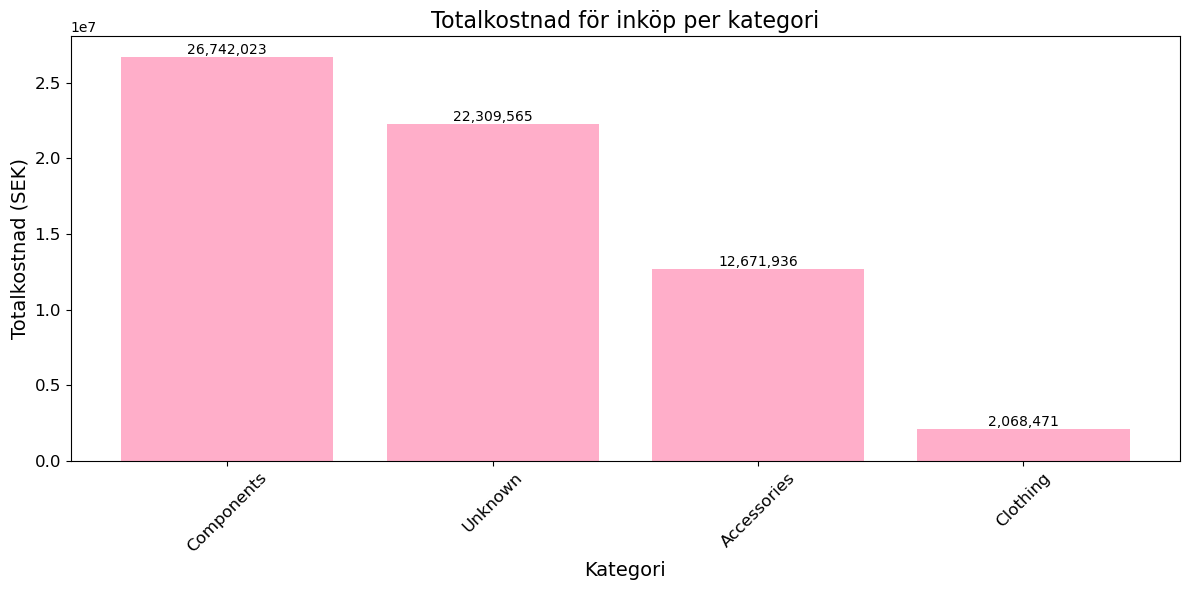

In [12]:
TotalCost = """
SELECT
    PC.Name AS CategoryName,
    SUM(POD.LineTotal) AS TotalPurchaseCost
FROM
    Purchasing.PurchaseOrderDetail POD
INNER JOIN
    Production.Product P
    ON POD.ProductID = P.ProductID
LEFT JOIN
    Production.ProductSubcategory PSC
    ON P.ProductSubcategoryID = PSC.ProductSubcategoryID
LEFT JOIN
    Production.ProductCategory PC
    ON PSC.ProductCategoryID = PC.ProductCategoryID
GROUP BY
    PC.Name
ORDER BY
    TotalPurchaseCost DESC;
"""

dataTotalCost = pd.read_sql(TotalCost, connection)

dataTotalCost['CategoryName'] = dataTotalCost['CategoryName'].fillna('Unknown')

plt.figure(figsize=(12, 6))
bars = plt.bar(dataTotalCost['CategoryName'], dataTotalCost['TotalPurchaseCost'], color='#FFAEC9')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 1e1,
        f'{height:,.0f}',
        ha='center', 
        va='bottom',  
        fontsize=10
    )

plt.title('Totalkostnad för inköp per kategori', fontsize=16)
plt.xlabel('Kategori', fontsize=14)
plt.ylabel('Totalkostnad (SEK)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

**Kommentar:**
Diagrammet visar de totala inköpskostnaderna per produktkategori. "Components" står för den största delen av inköpen, medan andra kategorier, som "Clothing", står för en mycket mindre andel. Detta kan bero på företagets produktionsbehov, men det kan också indikera en möjlighet att omfördela resurser.

In [20]:
CountDateBetween = """SELECT
    V.Name AS VendorName,
    AVG(DATEDIFF(DAY, POH.OrderDate, POH.ShipDate)) AS DaysBetweenOrderAndShip,
	AVG(DATEDIFF(DAY, POH.ShipDate, POD.DueDate)) AS DaysBetweenShipAndDue
FROM
    Purchasing.PurchaseOrderHeader POH
INNER JOIN
    Purchasing.PurchaseOrderDetail POD
    ON POH.PurchaseOrderID = POD.PurchaseOrderID
INNER JOIN
    Purchasing.Vendor V
    ON POH.VendorID = V.BusinessEntityID
WHERE
    POD.DueDate IS NOT NULL -- Endast ordrar med ett giltigt leveransdatum
GROUP BY
	V.Name
ORDER BY
    DaysBetweenOrderAndShip;
"""

dataCountDateBetween = pd.read_sql(CountDateBetween, connection)

filtered_data = pd.concat([dataCountDateBetween.head(7), dataCountDateBetween.tail(7)])

styled_filtered_data = (
    filtered_data.style
    .set_caption('Leveranstider - Topp 7 Snabbaste och Långsammaste Leverantörer')
    .set_table_styles([ 
        {
            'selector': 'caption',
            'props': [
                ('font-size', '18px'),
                ('text-align', 'center'),
                ('font-weight', 'bold'),
                ('color', '#FFF')  
            ]
        }
    ])
)

styled_filtered_data


,VendorName,DaysBetweenOrderAndShip,DaysBetweenShipAndDue
0,Federal Sport,9,5
1,Hybrid Bicycle Center,9,5
2,Comfort Road Bicycles,9,5
3,Speed Corporation,9,5
4,"Proseware, Inc.",9,5
5,"Premier Sport, Inc.",9,5
6,Allenson Cycles,9,5
79,Fitness Association,25,34
80,Integrated Sport Products,25,-14
81,G & K Bicycle Corp.,25,106


**Kommentar:**
Tabellen visar genomsnittliga leveranstider för varje leverantör, från orderdatum till skeppningsdatum och från skeppning till förfallodatum. Standarden är 9 dagar för att skicka en order och 5 dagar för leverans, vilket verkar vara rimligt för de flesta leverantörer. Vi ser här också fel i datat då vi ser minus i kolumnen DaysBetweenShipAndDue. 

**Analys av Purchasing-schemat**

Leverantörskostnader:
Vissa leverantörer har höga kostnader, vilket kan tyda på att företaget är beroende av dem. Det är viktigt att granska avtalen för att säkerställa att företaget får konkurrenskraftiga priser.

Orderstatus:
Den höga andelen slutförda ordrar är ett positivt tecken, men de avvisade ordrarna bör analyseras närmare för att identifiera orsakerna.

Leveranstider:
Leveranstiderna verkar rimliga, men några leverantörer kan ha avvikelser som bör åtgärdas för att säkerställa att produktionen inte störs.

**Rekommendationer:**

Optimera leverantörshanteringen:
Identifiera leverantörer med höga kostnader och analysera om det finns alternativ för att minska dessa kostnader.

Förbättra inköpsprocessen:
Granska orsakerna till avvisade ordrar och utveckla åtgärder för att minska dessa.

Utvärdera leveranstider:
Skapa en leverantörsbedömning baserad på leveranstider för att belöna effektiva leverantörer och stödja dem som behöver förbättras.

### Sales

Sales-tabellerna i AdventureWorks2022 innehåller information om företagets försäljning. Här kan vi analysera orderdata, kunddemografi och geografisk försäljning. Detta ger oss insikter om vilka produkter som säljer bäst och vilka regioner som genererar mest intäkter.

Vidare kommer jag visa vilka produkter som säljer bäst och sämst både i antal produkter och i intäkter. Sedan kontrollerar vi i vilka områden vi har flest kunder och säljer bäst.

In [21]:
TotalIncome = """SELECT
    P.Name AS ProductName,
    SUM(SOD.UnitPrice * SOD.OrderQTY) AS TotalIncome
FROM
    Sales.SalesOrderDetail SOD
INNER JOIN
    Production.Product P
    ON P.ProductID = SOD.ProductID
GROUP BY
    P.Name
ORDER BY
    TotalIncome DESC;
"""

dataTotalIncome = pd.read_sql(TotalIncome, connection)

top_10_income = dataTotalIncome.head(10)
bottom_10_income = dataTotalIncome.tail(10)

filtered_income = pd.concat([top_10_income, bottom_10_income])

styled_filtered_income_table = (
    filtered_income.style
    .format({'TotalIncome': '{:,.2f} $'})
    .set_caption('Topp 10 och botten 10 produkter - Total omsättning')
    .background_gradient(subset=['TotalIncome'], cmap='Greens')
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '18px'), ('text-align', 'center')]}
    ])
    .highlight_max(subset=['TotalIncome'], props='background-color: yellow; color: black;')
    .highlight_min(subset=['TotalIncome'], props='background-color: red; color: white;')
)

styled_filtered_income_table

,ProductName,TotalIncome
0,"Mountain-200 Black, 38","4,406,151.27 $"
1,"Mountain-200 Black, 42","4,014,067.80 $"
2,"Mountain-200 Silver, 38","3,696,486.47 $"
3,"Mountain-200 Silver, 42","3,441,292.54 $"
4,"Mountain-200 Silver, 46","3,436,090.79 $"
5,"Mountain-200 Black, 46","3,311,098.44 $"
6,"Road-250 Black, 44","2,518,299.76 $"
7,"Road-250 Black, 48","2,348,246.09 $"
8,"Road-250 Black, 52","2,012,447.77 $"
9,"Road-150 Red, 56","1,847,818.63 $"


**Kommentar:** Diagrammet visar att produkter som Mountain-200 säljer både i höga volymer och genererar hög intäkt, vilket gör dem till kärnprodukter.
Produkter med hög försäljningsvolym men låg intäkt kan indikera låga marginaler. Exempelvis kan detta vara ett resultat av kampanjer eller låga priser för att attrahera kunder.
Företaget bör analysera om dessa lågmarginalsprodukter kan förbättras i lönsamhet genom justering av pris eller kostnad. Denna information kan användas för att analysera trender i försäljning och eventuellt förbättra marknadsförings- eller lagerstrategier för de mindre populära produkterna.


In [13]:
CalculateTotal = """WITH TotalIncome AS (
    SELECT
        P.ProductID,
        P.Name AS ProductName,
        SUM(SOD.UnitPrice * SOD.OrderQTY) AS TotalIncome
    FROM
        Sales.SalesOrderDetail SOD
    INNER JOIN
        Production.Product P
        ON P.ProductID = SOD.ProductID
    GROUP BY
        P.ProductID, P.Name
),
TotalOutcome AS (
    SELECT
        P.ProductID,
        SUM(POD.LineTotal) AS TotalOutcome
    FROM
        Purchasing.PurchaseOrderDetail POD
    INNER JOIN
        Production.Product P
        ON POD.ProductID = P.ProductID
    GROUP BY
        P.ProductID
)
SELECT
    TI.ProductName,
    TI.TotalIncome,
    COALESCE(TOut.TotalOutcome, 0) AS TotalOutcome, -- Ersätt NULL med 0
    (TI.TotalIncome - COALESCE(TOut.TotalOutcome, 0)) AS Profit -- Beräkna Profit utan NaN
FROM
    TotalIncome TI
LEFT JOIN
    TotalOutcome TOut
    ON TI.ProductID = TOut.ProductID
ORDER BY
    Profit DESC;
"""

dataCalculateTotal = pd.read_sql(CalculateTotal, connection)

top_20_profit = dataCalculateTotal.nlargest(20, 'Profit')
bottom_20_profit = dataCalculateTotal.nsmallest(20, 'Profit') 

filtered_profit = pd.concat([top_20_profit, bottom_20_profit])

styled_filtered_profit_table = (
    filtered_profit.style
    .format({
        'TotalIncome': '{:,.2f}',
        'TotalOutcome': '{:,.2f}',
        'Profit': '{:,.2f}'
    })
    .set_caption('Topp 20 och botten 20 produkter - Vinst')
    .background_gradient(subset=['TotalIncome','Profit'], cmap='Greens') 
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '18px'), ('text-align', 'center'), ('font-weight', 'bold'), ('color', '#FFF')]}
    ])
    .highlight_max(subset=['TotalIncome', 'TotalOutcome', 'Profit'], props='background-color: yellow; color: black;') 
    .highlight_min(subset=['Profit'], props='background-color: red; color: white;') 
)

styled_filtered_profit_table

,ProductName,TotalIncome,TotalOutcome,Profit
0,"Mountain-200 Black, 38","4,406,151.27",0.00,"4,406,151.27"
1,"Mountain-200 Black, 42","4,014,067.80",0.00,"4,014,067.80"
2,"Mountain-200 Silver, 38","3,696,486.47",0.00,"3,696,486.47"
3,"Mountain-200 Silver, 42","3,441,292.54",0.00,"3,441,292.54"
4,"Mountain-200 Silver, 46","3,436,090.79",0.00,"3,436,090.79"
5,"Mountain-200 Black, 46","3,311,098.44",0.00,"3,311,098.44"
6,"Road-250 Black, 44","2,518,299.76",0.00,"2,518,299.76"
7,"Road-250 Black, 48","2,348,246.09",0.00,"2,348,246.09"
8,"Road-250 Black, 52","2,012,447.77",0.00,"2,012,447.77"
9,"Road-150 Red, 56","1,847,818.63",0.00,"1,847,818.63"


**Kommentar:** Tabellen visar det 20 topp och 20 botten sålda produkter. Vi ser tydligt vilka produkter som är de mest populära och vilka som säljer minst. Den gröna färgskalan framhäver mängden sålda produkter, där mörkare nyanser indikerar högre försäljningsvolymer. Det högsta värdet är markerat i gult, medan det lägsta värdet är markerat i rött, vilket gör det enkelt att identifiera topp- och bottenprodukter.

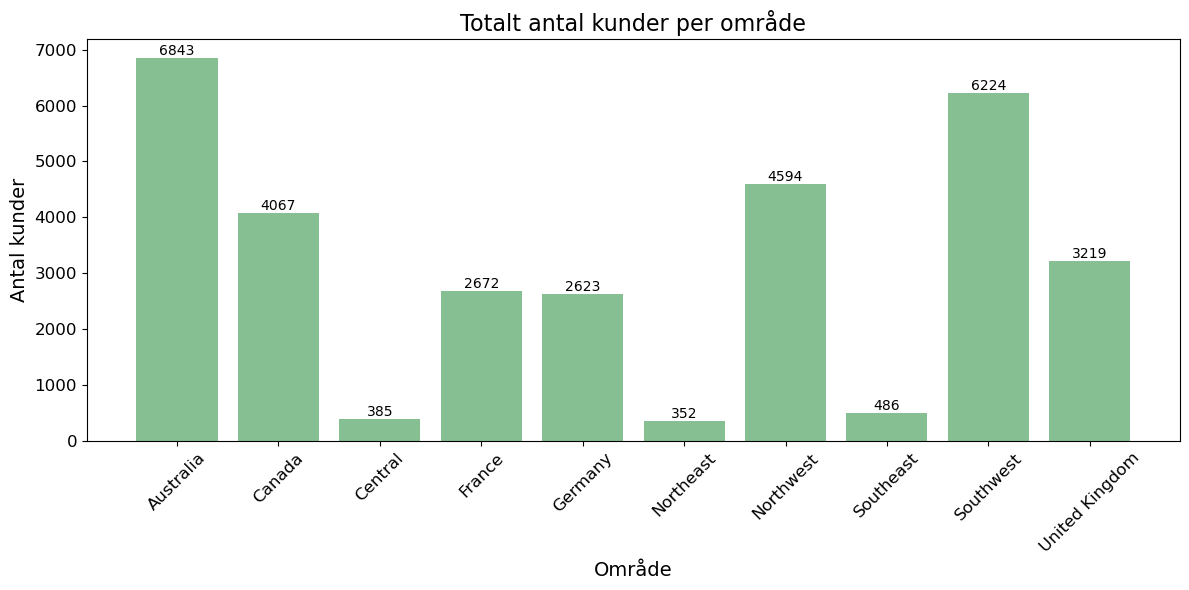

In [14]:
TotalCustomerTerritory = """
SELECT
    ST.Name AS Territory, -- Säkerställ att kolumnnamnet är 'Territory'
    COUNT(SOH.CustomerID) AS TotalCustomerTerritory
FROM
    Sales.SalesOrderHeader SOH
INNER JOIN
    Sales.Customer C
    ON C.CustomerID = SOH.CustomerID
INNER JOIN
    Sales.SalesTerritory ST
    ON ST.TerritoryID = SOH.TerritoryID
GROUP BY
    ST.Name
ORDER BY
    ST.Name
"""

dataTotalCustomerTerritory = pd.read_sql(TotalCustomerTerritory, connection)

if 'Name' in dataTotalCustomerTerritory.columns:
    dataTotalCustomerTerritory.rename(columns={'Name': 'Territory'}, inplace=True)

plt.figure(figsize=(12, 6))
bars = plt.bar(
    dataTotalCustomerTerritory['Territory'], 
    dataTotalCustomerTerritory['TotalCustomerTerritory'], 
    color='#86bf91'
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 1, 
        f'{int(height)}',  
        ha='center', 
        va='bottom',
        fontsize=10
    )

plt.title('Totalt antal kunder per område', fontsize=16)
plt.xlabel('Område', fontsize=14)
plt.ylabel('Antal kunder', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


**Kommentar:** Diagrammet visar att vissa områden, som Australien, Northwest och Southwest, har många kunder, vilket indikerar en stark marknadsnärvaro.
Områden med få kunder, som Central, Northeast eller Southeast, kan indikera en möjlighet att expandera företagets marknadsföring eller öka distributionen i dessa regioner.

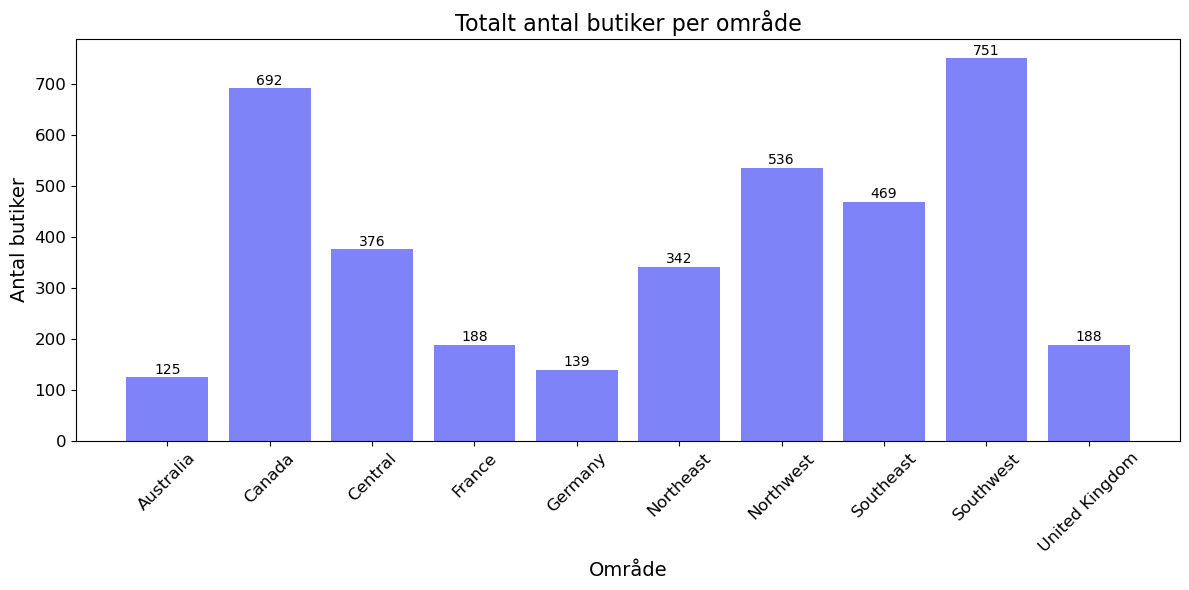

'plt.title():\nSätter titeln för diagrammet: "Totalt antal butiker per område".\nTextstorlek: 16.\n\nplt.xlabel() och plt.ylabel():\nSätter rubriker för X- och Y-axlar:\nX-axel: "Område".\nY-axel: "Antal butiker".\nTextstorlek: 14.\n\nplt.xticks(rotation=45):\nRoterar X-axelns etiketter 45 grader för att undvika överlappning.\nSätter textstorlek till 12.\n\nplt.yticks():\nJusterar Y-axelns etiketters textstorlek till 12.'

In [24]:
TotalStoreTerritory = """
SELECT
	ST.Name,
	COUNT(C.StoreID) AS TotalStoreTerritory
FROM
	Sales.SalesOrderHeader SOH
INNER JOIN
	Sales.Customer C
	ON C.CustomerID = SOH.CustomerID
INNER JOIN
	Sales.SalesTerritory ST
	ON ST.TerritoryID = SOH.TerritoryID
GROUP BY
	ST.Name
ORDER BY
	ST.Name
"""

dataTotalStoreTerritory = pd.read_sql(TotalStoreTerritory, connection)

if 'Name' in dataTotalStoreTerritory.columns:
    dataTotalStoreTerritory.rename(columns={'Name': 'Territory'}, inplace=True)

plt.figure(figsize=(12, 6))
bars = plt.bar(
    dataTotalStoreTerritory['Territory'], 
    dataTotalStoreTerritory['TotalStoreTerritory'], 
    color='#7E84F7'
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 1,  
        f'{int(height)}', 
        ha='center',
        va='bottom', 
        fontsize=10
    )

plt.title('Totalt antal butiker per område', fontsize=16)
plt.xlabel('Område', fontsize=14)
plt.ylabel('Antal butiker', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

**Kommentar:** Områden med många butiker, som Southwest och Canada, är troligtvis företagets huvudmarknader.
För områden med många kunder men få butiker kan företaget överväga att utöka antalet återförsäljare för att förbättra tillgängligheten och maximera försäljningen.
Jämförelser med kundantal per område kan ge insikter om eventuell obalanser mellan kundantal och antal butiker per område.

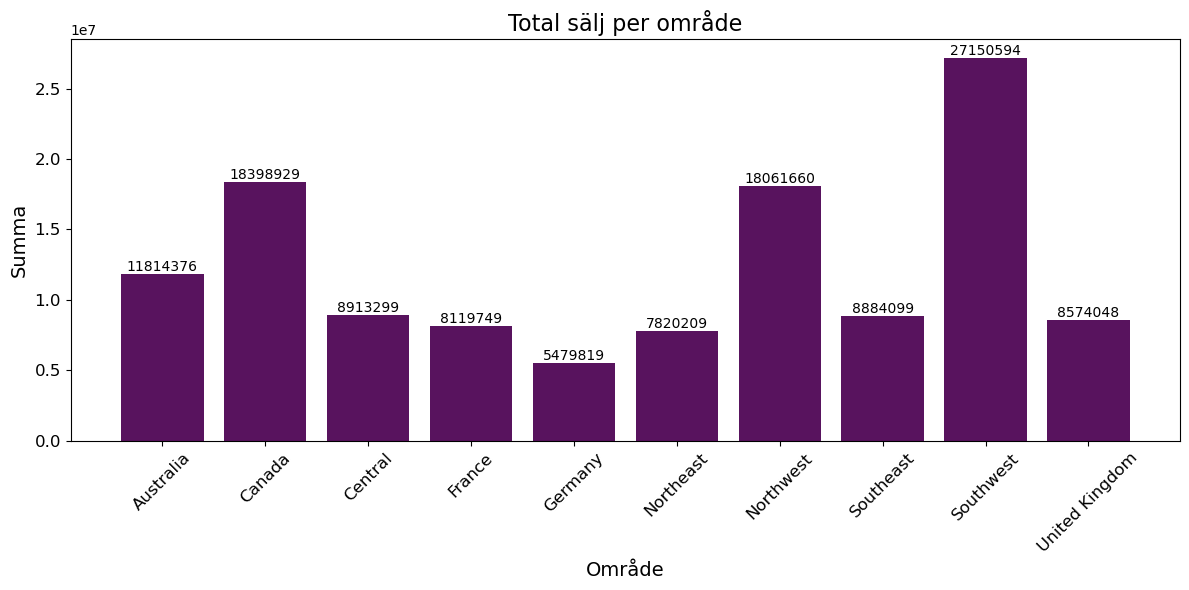

'plt.title():\nSätter titeln för diagrammet: "Total sälj per område".\nTextstorlek: 16.\n\nplt.xlabel() och plt.ylabel():\nSätter rubriker för X- och Y-axlar:\nX-axel: "Område".\nY-axel: "Summa".\nTextstorlek: 14.\n\nplt.xticks(rotation=45):\nRoterar X-axelns etiketter 45 grader för att undvika överlappning.\nSätter textstorlek till 12.\nplt.yticks():\nJusterar Y-axelns etiketters textstorlek till 12.'

In [25]:
TotalDueTerritory = """
SELECT
	ST.Name,
    SUM(SOH.TotalDue) AS TotalDue
FROM
    Sales.SalesOrderHeader SOH
INNER JOIN
	Sales.SalesTerritory ST
	ON ST.TerritoryID = SOH.TerritoryID
GROUP BY
	ST.Name
ORDER BY
	ST.Name
"""

dataTotalDueTerritory = pd.read_sql(TotalDueTerritory, connection)

if 'Name' in dataTotalDueTerritory.columns:
    dataTotalDueTerritory.rename(columns={'Name': 'Territory'}, inplace=True)

plt.figure(figsize=(12, 6))
bars = plt.bar(
    dataTotalDueTerritory['Territory'], 
    dataTotalDueTerritory['TotalDue'], 
    color='#58135E'
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 1,
        f'{int(height)}',
        ha='center',
        va='bottom', 
        fontsize=10
    )

plt.title('Total sälj per område', fontsize=16)
plt.xlabel('Område', fontsize=14)
plt.ylabel('Summa', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



**Kommentar:** Områdena med stort säljantal ger en bild av vilka regioner som driver den största delen av företagets omsättning.

**Analys av Sales-schemat**

Produkter: Mountain-200 framstår som den mest intäktsgenererande produkten. Samtidigt finns produkter som LL Tyre, vilka genererar låga intäkter. Detta kan indikera problem med efterfrågan eller brist på marknadsföring. Vissa produkter säljs i höga volymer men genererar ändå låga intäkter. Det kan bero på låga marginaler eller att produkterna köps som tilläggsprodukter snarare än huvudprodukter.

Lönsamhet: Analysen visar att vissa produkter med höga intäkter har låga marginaler, medan andra produkter med låga intäkter till och med kan ge förlust. Detta påverkar företagets totala lönsamhet.

Geografisk försäljning: Analysen av kundernas geografiska fördelning visar områden med hög kundtäthet, medan andra områden har få kunder. Totala intäkter per område belyser vilka regioner som driver majoriteten av företagets omsättning.

Återförsäljare: Vissa områden har få butiker trots hög kundtäthet. Detta begränsar potentiell försäljning och marknadsnärvaro.

**Rekommendationer**

Produkter: 1. Prioritera marknadsföring och lagerhållning av storsäljande produkter som Mountain-200 för att ytterligare driva intäkterna.
2. Utvärdera produkter med låga intäkter, som LL Tyre, för att avgöra om bristen på försäljning beror på efterfrågan eller otillräcklig marknadsföring.
3. För produkter med hög försäljningsvolym men låga marginaler, överväg att justera priser eller sänka produktionskostnader.

Lönsamhet: 4. Identifiera och minska produktionen av olönsamma produkter. 5. Fokusera på att maximera intäkter från produkter med höga marginaler.

Geografisk försäljning: 6. Investera i marknadsföring i områden med hög kundtäthet för att öka försäljningen ytterligare. 7. Utforska möjligheter att öka närvaron i regioner med låg försäljning, till exempel genom att lägga till fler återförsäljare.

Återförsäljare: 8. Öka antalet butiker i områden där kundantalet är högt men butiksantalet är lågt för att bättre möta efterfrågan. 9. Förbättra logistiken för att säkerställa snabb leverans och hög kundnöjdhet.

## Del två - en statistisk analys

#### Syfte:

Undersöka prestationer hos säljare i AdventureWorks2022 och skapa konfidensintervall för genomsnittlig försäljning per säljare.

#### Frågeställningar:

- Vilka säljare har sålt flest produkter?
- Vilka säljare har genererat störst försäljningsintäkter?
- Vad visar konfidensintervallet för genomsnittlig försäljning per säljare?

In [ ]:
BestSeller = """SELECT
    CONCAT(P.FirstName, ' ', P.LastName) AS SalesPersonName, -- Kombinera för- och efternamn
    SPr.Name AS StateProvinceName,
    E.Gender,
	DATEDIFF(YEAR, E.BirthDate, GETDATE()) AS Age,
	DATEDIFF(YEAR, E.HireDate, GETDATE()) AS Workyears,
    COUNT(DISTINCT SOH.CustomerID) AS UniqueCustomers,
	COUNT(SOD.SalesOrderID) AS TotalOrders,
    SUM(SOD.OrderQty) AS TotalProductsSold,
    SUM(SOD.LineTotal) AS TotalSales
FROM
    Sales.SalesOrderDetail SOD
INNER JOIN
    Sales.SalesOrderHeader SOH
    ON SOD.SalesOrderID = SOH.SalesOrderID
INNER JOIN
    Sales.SalesPerson SP
    ON SOH.SalesPersonID = SP.BusinessEntityID
INNER JOIN
    Person.Person P
    ON SP.BusinessEntityID = P.BusinessEntityID
INNER JOIN
	HumanResources.Employee E
	ON E.BusinessEntityID = P.BusinessEntityID
INNER JOIN
	HumanResources.EmployeeDepartmentHistory EDH
	ON EDH.BusinessEntityID = E.BusinessEntityID
INNER JOIN
	HumanResources.Department D
	ON D.DepartmentID = EDH.DepartmentID
INNER JOIN
    Person.Address A
    ON P.BusinessEntityID = A.AddressID
INNER JOIN
    Person.StateProvince SPr
    ON A.StateProvinceID = SPr.StateProvinceID
GROUP BY
    SP.BusinessEntityID, 
    P.FirstName, 
    P.LastName, 
    D.Name, 
    E.Gender, 
    DATEDIFF(YEAR, E.BirthDate, GETDATE()),
	DATEDIFF(YEAR, E.HireDate, GETDATE()),
    SPr.Name
ORDER BY
    TotalSales DESC;
"""

dataBestSeller = pd.read_sql(BestSeller, connection)

styled_BestSeller_table = (
    dataBestSeller.style
    .format({
        'TotalSales': '{:,.2f} $',
        'TotalOrders': '{:,}',
        'TotalProductsSold': '{:,}',
        'Age': '{:,.1f}',
        'Workyears': '{:,}'
    })
    .set_caption("Försäljning per säljare")
    .background_gradient(subset=['TotalSales'], cmap='Greens')  
    .background_gradient(subset=['Workyears', 'Age'], cmap='Blues') 
    .background_gradient(subset=['UniqueCustomers', 'TotalOrders', 'TotalProductsSold'], cmap='Oranges')  
    .highlight_max(subset=['TotalSales', 'TotalProductsSold'], props='background-color: yellow; color: black;')  
    .highlight_min(subset=['TotalSales', 'TotalProductsSold'], props='background-color: red; color: white;')  
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '18px'), ('text-align', 'center'), ('font-weight', 'bold')]}
    ])
)

styled_BestSeller_table

,SalesPersonName,StateProvinceName,Gender,Age,Workyears,UniqueCustomers,TotalOrders,TotalProductsSold,TotalSales
0,Linda Mitchell,Washington,F,44.0,13,69,"7,107","27,229","10,367,007.43 $"
1,Jillian Carson,Washington,F,62.0,13,121,"7,825","27,051","10,065,803.54 $"
2,Michael Blythe,Washington,M,56.0,13,118,"7,069","23,058","9,293,903.00 $"
3,Jae Pak,Washington,F,56.0,12,62,"6,738","26,231","8,503,338.65 $"
4,Tsvi Reiter,Washington,M,50.0,13,74,"5,417","16,431","7,171,012.75 $"
5,Shu Ito,Washington,M,56.0,13,35,"4,545","15,397","6,427,005.55 $"
6,José Saraiva,Washington,M,61.0,13,67,"4,437","15,220","5,926,418.36 $"
7,Ranjit Varkey Chudukatil,Washington,M,49.0,12,34,"3,419","14,085","4,509,888.93 $"
8,David Campbell,Washington,M,50.0,13,31,"2,247","8,172","3,729,945.35 $"
9,Garrett Vargas,Washington,M,49.0,13,38,"3,284","11,544","3,609,447.21 $"


**Kommentar**:
Tabellen visar information om säljarens ålder, kön och hur länge de har arbetat på företaget. Vi ser varje säljares kunder, totala ordrar, totala produkter och totalförsäljning ($).
Linda Michell och Jillian Carson har höga försäljningssiffror medan Amy Alberts och Syed Abbas har låga försäljningssiffror. 

In [42]:
from scipy.stats import norm
import numpy as np
# medelvärde
mean_sales = dataBestSeller['TotalSales'].mean()
print(f'Medelvärdet av TotalSales: {mean_sales:.2f}$')

# standardavvikelse
std_sales = dataBestSeller['TotalSales'].std()
print(f'Standardavvikelsen av TotalSales: {std_sales:.2f}$')

# medelfel
n = len(dataBestSeller)  # Antal observationer (säljare)
sem_sales = std_sales / np.sqrt(n)
print(f'Standardfelet av TotalSales: {sem_sales:.2f}$')

# z-värde för konfidensintervall två sidor
confidence_level = 0.95
z_value_twoside = norm.ppf(1 - (1 - confidence_level)/2)
print(f'Z-värde för {confidence_level * 100:.0f}% konfidensintervall: {z_value_twoside:.3f}')

# z-värde för konfidensintervall en sida
z_value_oneside = norm.ppf(1-(1 - confidence_level))
print(f'Z-värde för {confidence_level * 100:.0f}% konfidensintervall: {z_value_oneside:.3f}')

# konfidensintervall två sidor
lower_bound_2 = mean_sales - (z_value_twoside * sem_sales)
upper_bound_2 = mean_sales + (z_value_twoside * sem_sales)
print(f'Konfidensintervall två sidig ({confidence_level * 100:.0f}%): {lower_bound_2:.2f}$ till {upper_bound_2:.2f}$')

# konfidensintervall en sida
lower_bound_1 = mean_sales - (z_value_oneside * sem_sales)
upper_bound_1 = mean_sales + (z_value_oneside * sem_sales)
print(f'Konfidensintervall två sidig ({confidence_level * 100:.0f}%): {lower_bound_1:.2f}$ till {upper_bound_1:.2f}$')

Medelvärdet av TotalSales: 4734570.83$
Standardavvikelsen av TotalSales: 3400911.60$
Standardfelet av TotalSales: 824842.22$
Z-värde för tvåsidigt 95% konfidensintervall: 1.960
Konfidensintervall tvåsidigt (95%): 3117909.79$ till 6351231.88$
Z-värde för ensidigt 95% konfidensintervall: 1.645
Konfidensintervall ensidigt (95%): 3377826.11$ till 6091315.55$


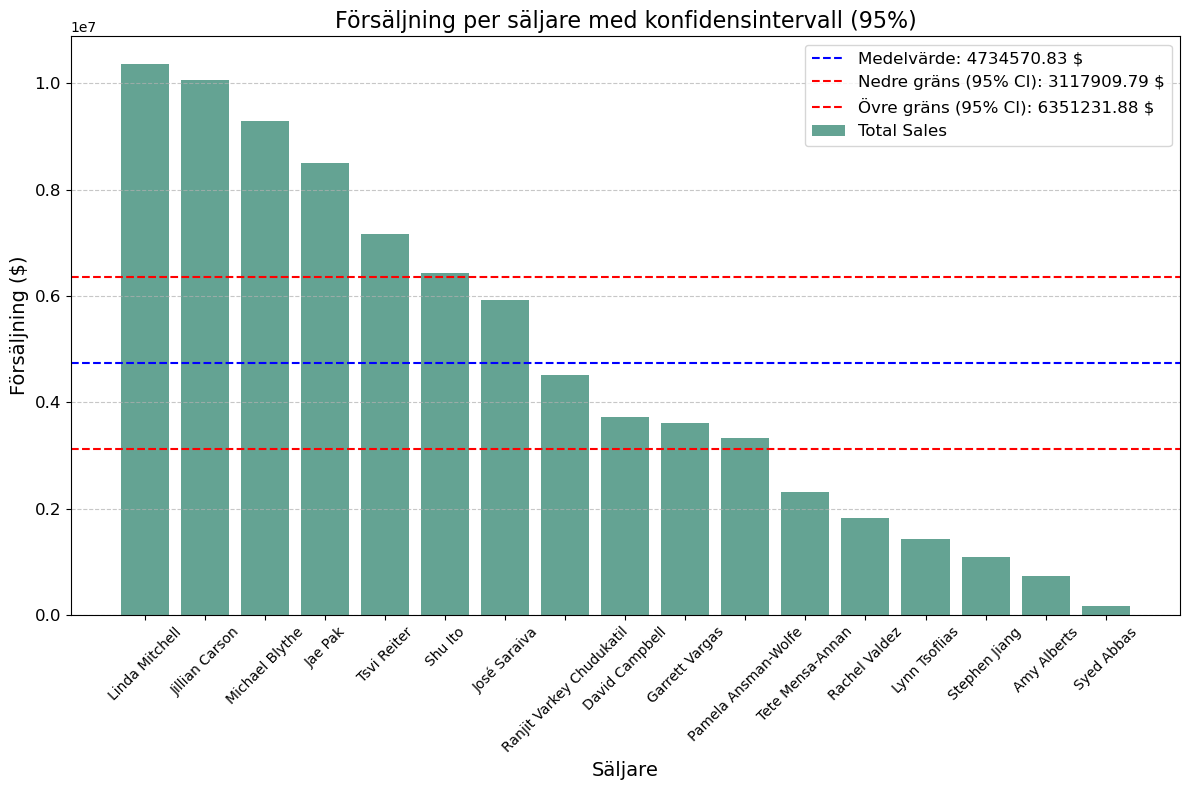

In [60]:
dataBestSeller_sorted = dataBestSeller.sort_values('TotalSales', ascending=False)

plt.figure(figsize=(12, 8))

plt.bar(dataBestSeller_sorted['SalesPersonName'], dataBestSeller_sorted['TotalSales'], color='#64A393', label='Total Sales')

plt.axhline(mean_sales, color='blue', linestyle='--', label=f'Medelvärde: {mean_sales:.2f} $')

plt.axhline(lower_bound_2, color='red', linestyle='--', label=f'Nedre gräns (95% CI): {lower_bound_2:.2f} $')
plt.axhline(upper_bound_2, color='red', linestyle='--', label=f'Övre gräns (95% CI): {upper_bound_2:.2f} $')

plt.title('Försäljning per säljare med konfidensintervall (95%)', fontsize=16)
plt.xlabel('Säljare', fontsize=14)
plt.ylabel('Försäljning ($)', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

**Kommentar**:
Detta diagram visar hur mycket varje säljare har sålt i total försäljning och jämför detta med medelvärdet och konfidensintervallens gränser.
De högsta säljarna, som Linda Mitchell och Jillian Carson, ligger långt över medelvärdet och till och med utanför det övre konfidensintervallet. Detta tyder på exceptionella prestationer.
De lägre säljarna, som Syed Abbas, Stephan Jiang och Amy Alberts, ligger långt under det nedre konfidensintervallet. Här kan vi analysera om dessa säljare har utmaningar som kan behöva stöd eller resurser.

In [49]:
snittsalescustomer = dataBestSeller['TotalSales'] / dataBestSeller['UniqueCustomers']

# medelvärde
mean_sales_snitt = snittsalescustomer.mean()
print(f'Medelvärdet av TotalSales: {mean_sales_snitt:.2f}$')

# standardavvikelse
std_sales_snitt = snittsalescustomer.std()
print(f'Standardavvikelsen av TotalSales: {std_sales_snitt:.2f}$')

# medelfel
n = len(snittsalescustomer)  # Antal observationer (säljare)
sem_sales_snitt = std_sales_snitt / np.sqrt(n)
print(f'Standardfelet av TotalSales: {sem_sales_snitt:.2f}$')

# konfidensintervall två sidor
lower_bound_2_snitt = mean_sales_snitt - (z_value_twoside * sem_sales_snitt)
upper_bound_2_snitt = mean_sales_snitt + (z_value_twoside * sem_sales_snitt)
print(f'Konfidensintervall två sidig ({confidence_level * 100:.0f}%): {lower_bound_2_snitt:.2f}$ till {upper_bound_2_snitt:.2f}$')

Medelvärdet av TotalSales: 89448.36$
Standardavvikelsen av TotalSales: 47519.91$
Standardfelet av TotalSales: 11525.27$
Konfidensintervall två sidig (95%): 66859.24$ till 112037.48$


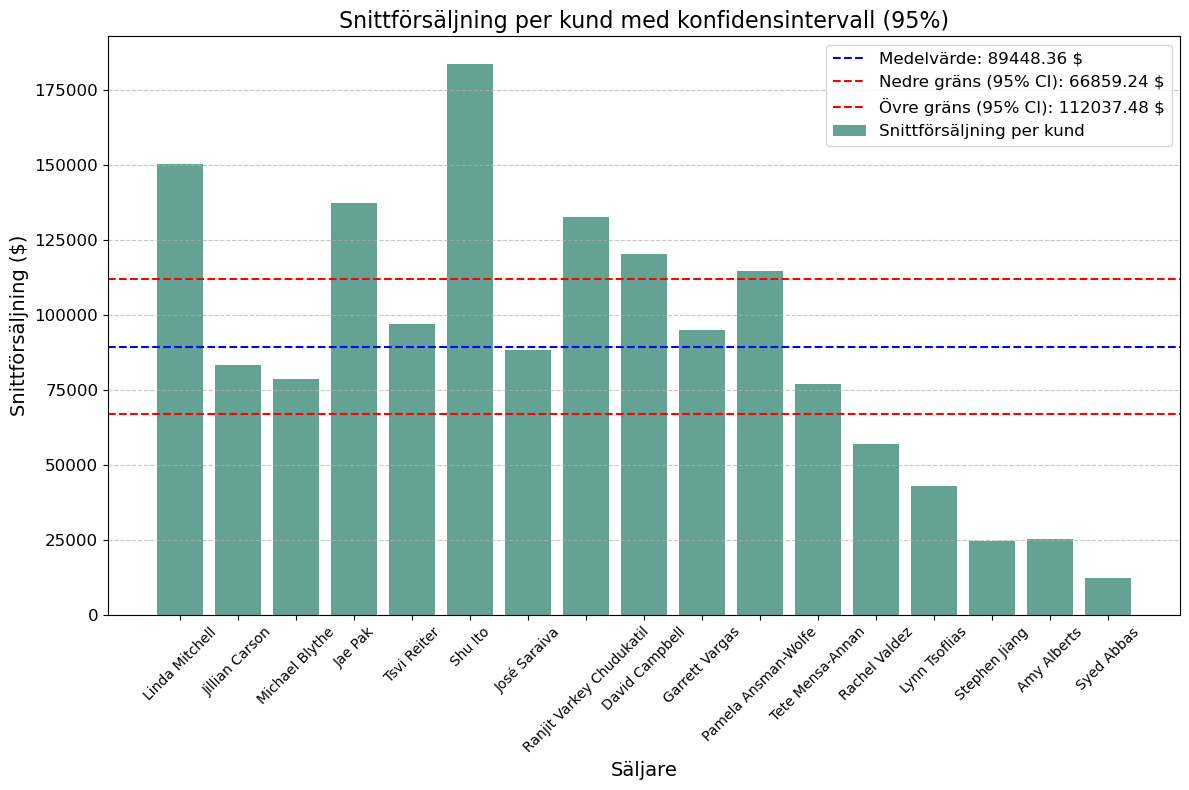

In [59]:
plt.figure(figsize=(12, 8))

plt.bar(dataBestSeller['SalesPersonName'], snittsalescustomer, color='#64A393', label='Snittförsäljning per kund')

plt.axhline(mean_sales_snitt, color='blue', linestyle='--', label=f'Medelvärde: {mean_sales_snitt:.2f} $')
plt.axhline(lower_bound_2_snitt, color='red', linestyle='--', label=f'Nedre gräns (95% CI): {lower_bound_2_snitt:.2f} $')
plt.axhline(upper_bound_2_snitt, color='red', linestyle='--', label=f'Övre gräns (95% CI): {upper_bound_2_snitt:.2f} $')

plt.title('Snittförsäljning per kund med konfidensintervall (95%)', fontsize=16)
plt.xlabel('Säljare', fontsize=14)
plt.ylabel('Snittförsäljning ($)', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Kommentar**:
Shu Ito har den högsta snittförsäljningen per kund, vilket kan indikera att hennes kunder tenderar att göra större beställningar. 
Jillian Carson, trots att de har de högsta totala försäljningarna, har mer genomsnittlig snittförsäljning per kund. Detta kan indikera att de når fler kunder snarare än att sälja mycket till enskilda kunder. Linda Mitchell har högst försäljningsiffror, dock färre kunder men hög genomsnittlig snittförsäljning per kund.
Syed Abbas, Amy Alberts och Stephen Jiang har både låg total försäljning och låg snittförsäljning per kund. Här kan vi undersöka kundens engagemang eller säljarens strategi.

**Analys av resultaten**

*Försäljning per säljare*

Toppsäljare:
Linda Mitchell och Jillian Carson är de två toppsäljarna, med försäljning som är klart över medelvärdet och närmar sig den övre gränsen för konfidensintervallet. Detta tyder på att de presterar betydligt bättre än genomsnittet. 

Medelpresterande säljare:
Fem säljare presterar inom det tvåsidiga konfidensintervallet. Detta innebär att deras försäljning är i linje med förväntningarna och den naturliga variationen i datan.

Lågpresterande säljare:
Företaget har hela sex säljare däribland, Syed Abbas och Amy Alberts som ligger långt under det nedre gränsen för konfidensintervallet. Detta kan indikera att deras försäljning är signifikant lägre än det förväntade genomsnittet och kan vara ett område som kräver förbättring. Det är tio säljare som ligger under medelvärdet. 

Spridning:
Diagrammet visar en stor spridning i försäljning mellan säljarna, med några få säljare som har mycket hög försäljning, medan andra ligger långt under medelvärdet.

Jämförelse med konfidensintervallet:
Säljare utanför konfidensintervallet (både över och under) kan betraktas som avvikare. De över konfidensintervallet presterar exceptionellt bra. De under konfidensintervallet kan behöva extra stöd eller resurser för att förbättra sin prestation.

Slutsatser:
Möjligheter till förbättring: Säljare under konfidensintervallet bör undersökas närmare för att identifiera orsaker till deras låga prestation och skapa åtgärdsplaner. Stöd till toppsäljare: Topprestationer bör belönas och deras strategier kan användas som inspiration för andra.

*Snittförsäljning per kund*

Jillian Carson har flest kunder (121) men en relativt lägre snittförsäljning per kund jämfört med Shu Ito, som har högre genomsnitt per kund.
Säljare som har höga totalförsäljningssiffror men lågt antal kunder kan potentiellt dra nytta av att utöka sin kundbas.
Amy Alberts, Stephan Jiang och Syed Abbas har få unika kunder och låga totalsiffror. Detta kan vara en indikation på områden där företaget kan förbättra säljstödet.    

### Executive summary

Analysen av HumanResources visar att många anställda närmar sig pensionsåldern, vilket kräver en strategisk rekryteringsplan och åtgärder för att säkerställa kompetensöverföring till yngre medarbetare. Företaget bör också utreda om löneskillnader är strukturella eller baserade på prestation och erfarenhet. Person-analysen indikerar en begränsad geografisk spridning med få anställda utanför Washington. Företaget rekommenderas överväga att expandera globalt för att öka försäljningen.

Production-analysen visar att många produkter är okategoriserade och att flera har lågt lagersaldo. Företaget bör förbättra lagerhanteringen för att optimera resurser. Inom Purchasing framgår att vissa leverantörer är kostsamma; en analys av alternativa leverantörer kan minska utgifterna. Sales-analysen lyfter fram Mountain-200 som den mest lönsamma produkten. Företaget bör granska produkter med hög försäljningsvolym men låga marginaler och utforska möjligheter att öka intäkterna, exempelvis genom prishöjningar eller produktionskostnadsminskningar.

Slutligen visar den statistiska analysen av försäljning per säljare en hög variation i prestation. Säljare under konfidensintervallet bör undersökas för att identifiera förbättringsområden och skapa åtgärdsplaner. Samtidigt bör toppsäljare belönas, och deras strategier användas som inspiration för att lyfta andra säljares prestationer.